In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import StandardScaler

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

normalizer = StandardScaler()
normalizer.fit(train_features)
train_features = normalizer.transform(train_features)
test_features = normalizer.transform(test_features)

In [2]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_features, train_labels)
print(f"R2 = {lr.score(test_features, test_labels)}")

from sklearn.metrics import mean_squared_error

print(f"MSE = {mean_squared_error(lr.predict(test_features), test_labels)}")

R2 = 0.8442412485817241
MSE = 10.172092283687613


In [4]:
from keras import layers

linear_model = keras.Sequential([
    layers.Dense(units=16, activation='relu'),
    layers.Dropout(rate=0.2),
    # layers.Dense(units=16, activation='relu'),
    # layers.Dropout(rate=0.2),
    layers.Dense(units=1),
])

# linear_model = keras.Sequential([
#     normalizer,
#     layers.Dense(units=1),
# ])

linear_model.compile(    
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.1),
    loss='mse')

In [5]:
history = linear_model.fit(
    train_features,
    np.array(train_labels),
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

2024-12-10 12:39:15.084797: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-10 12:39:15.084818: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-10 12:39:15.084825: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-10 12:39:15.084855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-10 12:39:15.084869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-10 12:39:15.156711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Yo

,loss,val_loss
95,25.685808,12.987852
96,22.012922,13.468208
97,20.646728,11.757643
98,19.286787,13.005950
99,17.480046,17.563066


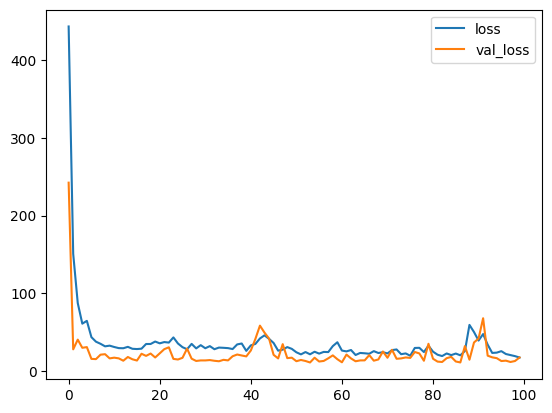

In [6]:
pd.DataFrame(history.history).plot()
pd.DataFrame(history.history).tail()

In [7]:
train_features

array([[-0.87073567, -1.01107037, -0.78530384, ..., -0.46589083,
        -0.49601587,  0.77591289],
       [-0.87073567, -0.53106418, -0.44351791, ..., -0.46589083,
        -0.49601587,  0.77591289],
       [ 1.48625572,  1.48496183,  1.44945034, ..., -0.46589083,
        -0.49601587,  0.77591289],
       ...,
       [-0.87073567, -0.83826814, -0.31206178, ..., -0.46589083,
         2.01606452, -1.28880447],
       [-0.87073567, -1.07827123, -1.153381  , ..., -0.46589083,
         2.01606452, -1.28880447],
       [-0.87073567, -0.84786826, -0.49610036, ...,  2.1464256 ,
        -0.49601587, -1.28880447]])

In [8]:
from disentanglement.models.architectures import get_dropout_from_backbone
from disentanglement.models.gaussian_logits_models import train_gaussian_logits_model
from tensorflow.keras import backend as K


# disable_eager_execution()
def get_auto_mpg_backbone(n_training_samples=0):
    linear_model = keras.Sequential([
        layers.Input(9),
        layers.Dense(units=16, activation='relu')])
    return linear_model

  0%|                                                                                                                                                                                                                                                                                          | 0/1560 [00:00<?, ?it/s]

In [9]:
def architecture(**_):
    return get_dropout_from_backbone(backbone_func=get_auto_mpg_backbone, hidden_size=16)

In [10]:
model = train_gaussian_logits_model(architecture, np.array(train_features), np.array(train_labels), n_classes=0, epochs=100_000, regression=True)

2024-12-10 12:39:23.552981: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_3/bias/v/Assign' id:654 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_3/bias/v, training_2/Adam/dense_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
  0%|▏                                                                                                                                                                                                                                                                           | 1/1560 [30:09<783:49:05, 1809.97s/it]

In [11]:
preds, ale_std, epi_std = model.predict(np.array(test_features), num_samples=100, disentangle_uncertainty=True)

/Users/ivopascal/.local/share/virtualenvs/uq_disentanglement_comparison-mONOvMcl/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-10 13:09:33.336988: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_4/BiasAdd' id:380 op device:{requested: '', assigned: ''} def:{{{node dense_4/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_4/MatMul, dense_4/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [12]:
mean_squared_error(preds, test_labels,)

25.47515160320023

In [13]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(preds, test_labels)

3.9472815660329967

In [14]:
print(ale_std.mean())
print(epi_std.mean())

603.7401
1.2813471e-05


In [15]:
np.array(train_features).shape

(314, 9)